In [1]:
import numpy as np
from numpy import log, sin, cos, exp, tan, pi
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

%matplotlib inline
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

def density(To,Sppt):
    rho_fresh=1000*(1-(To +288.9414)/(508929.2*(To+68.12963))*(To-3.9863)**2)
    Acoef = 0.824493 - 0.0040899*To + 0.000076438*To**2 -0.00000082467*To**3 + 0.0000000053675*To**4
    Bcoef = -0.005724 + 0.00010227*To - 0.0000016546*To**2
    return rho_fresh + Acoef*Sppt + Bcoef*Sppt**(3/2) + 0.00048314*Sppt**2

def visc(To):
    return 2.7488e-07+1.4907e-06*exp(-0.034812*To)

def settlingvel(d_in,dp,nf,coef,rhos,T,S):
    rho = density(T,S)
    nu = visc(T)
    mu = nu*rho
    g = 9.81 # acc of gravity
    print(nu)
    Rs = (rhos-rho)/rho # submerged specific gravity

    if coef == 1:
        b1 = 120
        b2 = 0
    elif coef == 2:
        b1 = 20   # nominal diameter natural sand = C1 from F&C
        b2 = 0.91 # nominal diameter natural sand = sqrt(0.75*C2) from F&C
        # b1 = 20    # coef from Winterwerp
        # b2 = 1.258 # coef from Winterwerp
    else:
        b1 = 18 # sieve diameter natural sand = C1 from F&C
        b2 = 0.866 # sieve diameter natural sand = sqrt(0.75*C2) from F&C

    d = d_in/10**6
    dp = dp/10**6

    return (g*Rs*d**(nf-1))/(b1*nu*dp**(nf-3)+b2*np.sqrt(g*Rs*d**nf*dp**(nf-3)))

In [2]:
""" --- User input ----------------------------- """

datadir = '/Users/strom-adm/Floc-Processing/Mississippi-River/6-30_1045_Main-1-06302020115822-1621/'
resultsfolder = 'Output-Main-summer-1/'
station = 'Main-summer-1'

# datadir = '/Users/strom-adm/Floc-Processing/Mississippi-River/6-30_1045_Main1-2-06302020123740-1321/'
# resultsfolder = 'Output-Main-summer-2/'
# station = 'Main-summer-2'

# datadir = '/Users/strom-adm/Floc-Processing/Mississippi-River/1-9_1245_SWP1-01092021134452-2/'
# resultsfolder = 'Output-SWP1/'
# station = 'SWP1'

# datadir = '/Users/strom-adm/Floc-Processing/Mississippi-River/1-9_1100_VMC-01092021122925-1521/'
# resultsfolder = 'VMC-winter/'
# station = 'VMC-winter'

# datadir = '/Users/strom-adm/Floc-Processing/Barataria-Bay/Processed-data/1-13_1155_barN/' # path to the data
# resultsfolder = 'Output-Barataria/'
# station = 'Barataria Bay'

# datadir = '/Users/strom-adm/Floc-Processing/Barataria-Bay/Processed-data/1-13_1300_dosgris-cleaned/'
# resultsfolder = 'Output-Dosgris/'
# station = 'Bay Dosgris'

# datadir = '/Users/strom-adm/Floc-Processing/Barataria-Bay/Processed-data/1-13_1340_perot/'
# resultsfolder = 'Output-Perot/'
# station = 'Perot'

# datadir = '/Users/strom-adm/Floc-Processing/Barataria-Bay/Processed-data/1-13_1340_perot-cleaned/'
# resultsfolder = 'Output-Perot-Cleaned/'
# station = 'Perot'

# datadir = '/Users/strom-adm/Floc-Processing/Barataria-Bay/Processed-data/1-13_1445_ICWW/'
# resultsfolder = 'Output-GIWW/'
# station = 'GIWW'

ext = '*PDF*.csv'    # distribution files

"""  ------------------------------------------- """

# Find all of the data files and store the names 

files = sorted(glob.glob(datadir+ext))
    
#Print the file names and index value for each file

print('--- data ---')
for i in range(0,len(files)):
    print('file: ',files[i],'(index: ',i,')')

--- data ---
file:  /Users/strom-adm/Floc-Processing/Mississippi-River/6-30_1045_Main-1-06302020115822-1621/ProcData_2_PDF-profile.csv (index:  0 )


In [3]:
""" --- User input ----------------------------- """

exclude = []
           # enter the index number(s), separated by commas, to exclude certain distributions, or make blank to keep all

# VMC - summer
distlocation = np.array(['profile'])
    
# # VMC - winter
# distlocation = np.array(['mid-depth', 'near-bed','surface'])

# # SWP1
# distlocation = np.array(['bottom', 'mid-depth-1', 'mid-depth-2', 'mid-depth-3','mid-depth-4','mid-depth-5','surface'])
# distlocation = np.array(['bottom', 'mid-depth-1', 'mid-depth-2', 'mid-depth-3','mid-depth-4','mid-depth-5','profile','surface'])
    
# distlocation = np.array(['bottom','mid-depth', 'surface'])           
# distlocation = np.array(['mid-depth', 'near-bed','surface'])
# distlocation = np.array(['bottom', 'mid-depth', 'near-bed', 'surface'])
# distlocation = np.array(['bottom', 'surface'])  

vol_or_freq = 'vol' # the data type in the second column ('vol' or 'frac')

T = 6.5    # average water temp in deg C
S = 0.0
dp = 6.6       # primary particles in micron
nf = 2.49     # floc fractal dimension
coef = 1      # settling vel coefs(1=visc floc, 2 = F&C nominal, 3 = F&C sieve)     
rhos = 2650  # density of primary particles

"""  ------------------------------------------- """

files=np.delete(files, exclude)

distlocation = np.append(distlocation, 'depth-avg')

for i in range(0,len(files)):
    data = pd.read_csv(files[i])

    if vol_or_freq == 'vol':
        data.columns = ['d_mu', 'vol_muL']
        data['fraction']= data.vol_muL/sum(data.vol_muL)
    else:
        data.columns = ['d_mu', 'fraction']
    
    if i==0:
        ws = settlingvel(np.array(data.d_mu),dp,nf,coef,rhos,T,S)            
        data['ws_mm_s']=ws*1000
        datamaster = data[['d_mu', 'ws_mm_s', 'fraction']].copy()
    else:
        datamaster = pd.concat([datamaster,data.fraction], axis = 1)
    
    datamaster.rename(columns={'fraction': 'frac_'+distlocation[i]}, inplace=True)

datamaster['frac_avg']=datamaster.iloc[:,2:2+len(files)].sum(axis=1)/len(files)

display(datamaster)

if os.path.isdir(resultsfolder) != 1:
    os.mkdir(resultsfolder)
    
datamaster.to_csv(resultsfolder+'/'+station+'_distributions.csv', index=False)

1.463707834072206e-06


,d_mu,ws_mm_s,frac_profile,frac_avg
0,2.07,0.000713,0.000000e+00,0.000000e+00
1,2.44,0.000911,0.000000e+00,0.000000e+00
2,2.88,0.001167,0.000000e+00,0.000000e+00
3,3.40,0.001494,0.000000e+00,0.000000e+00
4,4.01,0.001911,5.480488e-08,5.480488e-08
5,4.73,0.002444,9.724193e-07,9.724193e-07
6,5.58,0.003126,3.790559e-06,3.790559e-06
7,6.59,0.004006,1.260720e-05,1.260720e-05
8,7.77,0.005120,3.116990e-05,3.116990e-05
9,9.17,0.006553,6.288303e-05,6.288303e-05


profile  - distribution average settling velocity, ws [mm/s] = 0.55
depth-avg  - distribution average settling velocity, ws [mm/s] = 0.55


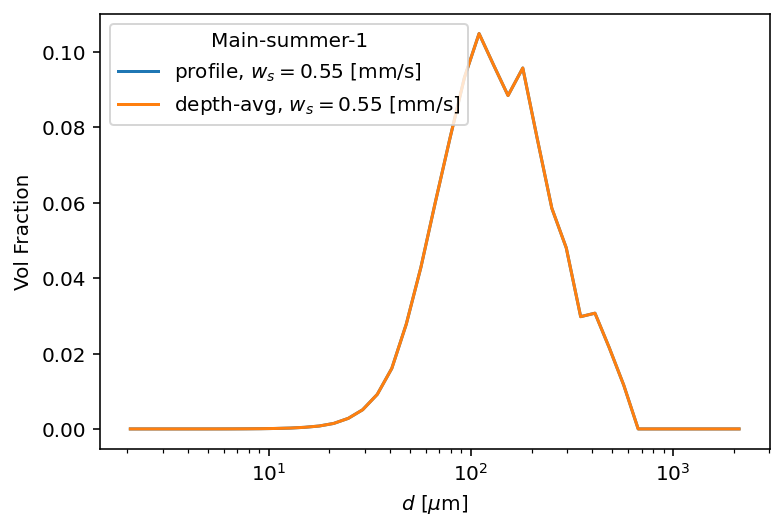

In [4]:
ws_mm_s_avg=np.zeros(len(files)+1)
for i in range(0,len(files)+1):
    ws_mm_s_avg[i] = sum(datamaster.ws_mm_s*datamaster.iloc[:,2+i])
    print(distlocation[i],' - distribution average settling velocity, ws [mm/s] =',np.around(ws_mm_s_avg[i],decimals=2))
    
fig, ax = plt.subplots()
for i in range(0,len(files)+1):
    ax.plot(datamaster.d_mu,datamaster.iloc[:,2+i],label=distlocation[i]+', $w_s=$'+str(np.around(ws_mm_s_avg[i],decimals=2))+' [mm/s]')
ax.set_xlabel('$d$ [$\mu$m]')
ax.set_ylabel('Vol Fraction')
# ax.set_xlim(5,)
ax.set_xscale('log') 
plt.legend(loc=2, ncol=1,  title=station);

plt.savefig(resultsfolder+'/'+station+'_distributions.pdf')

In [5]:
d16=np.zeros(len(files)+1)
d50=np.zeros(len(files)+1)
d84=np.zeros(len(files)+1)

centers = np.array(datamaster.d_mu)
upperedge = exp(0.5*(log(centers[:-1])+log(centers[1:])))
    
for i in range(0,len(files)+1):
    cumulative = np.cumsum(datamaster.iloc[:,2+i])
    ff = cumulative/cumulative[len(cumulative)-1]
    fracfiner = ff[0:-1]
    
    d16[i]=np.interp(0.16,fracfiner,upperedge)
    d50[i]=np.interp(0.50,fracfiner,upperedge)
    d84[i]=np.interp(0.84,fracfiner,upperedge)

In [6]:
wsdf = pd.DataFrame(distlocation, columns = ['location'])
wsdf['d16_um']=d16
wsdf['d50_um']=d50
wsdf['d84_um']=d84
wsdf['ws_avg_mm_s']=ws_mm_s_avg
wsdf['Temp']=T
wsdf['Salinity']=S
wsdf['dp_micron']=dp
wsdf['fractal_dim']=nf
wsdf['rho_sed_kg_m3']=rhos
wsdf.to_csv(resultsfolder+'/'+station+'_sizestats_ws_calcs.csv', index=False)
wsdf

,location,d16_um,d50_um,d84_um,ws_avg_mm_s,Temp,Salinity,dp_micron,fractal_dim,rho_sed_kg_m3
0,profile,71.344517,132.451321,260.388748,0.554969,6.5,0.0,6.6,2.49,2650
1,depth-avg,71.344517,132.451321,260.388748,0.554969,6.5,0.0,6.6,2.49,2650
